In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch_geometric.loader import DataLoader
from data_utils import *
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
include_hydrogen = False

properties = ["homo", "lumo", "r2"]

prop_norm_df = create_or_load_property_norm_df()
    
# create dataset and dataloaders
dataset = create_qm9_dataset(
    device=device, 
    include_hydrogen=False, 
    refresh_data_cache=False,
    properties=properties,
    prop_norm_df=prop_norm_df
)

_, val_dataset, _ = create_qm9_data_split(dataset=dataset)

mol_indices = [8, 190, 59, 101]
val_dataset = val_dataset[mol_indices]

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# old: ./checkpoints/graph_vae_20240416_221922.pt
model = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240502_125508.pt").to(device)
model.eval()
# old: ./checkpoints/graph_vae_20240416_225315.pt
model_split = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240503_021631.pt").to(device)
model_split.eval()
print()

In [8]:
y_list = []
for batch in tqdm(loader):
    y = model.denormalize_properties(batch.y)
    y_list.append(y)
    
y = torch.cat(y_list, dim=0)
print(y.shape)

  1%|          | 3/501 [00:00<00:50,  9.84it/s]

100%|██████████| 501/501 [01:03<00:00,  7.87it/s]

torch.Size([128056, 3])


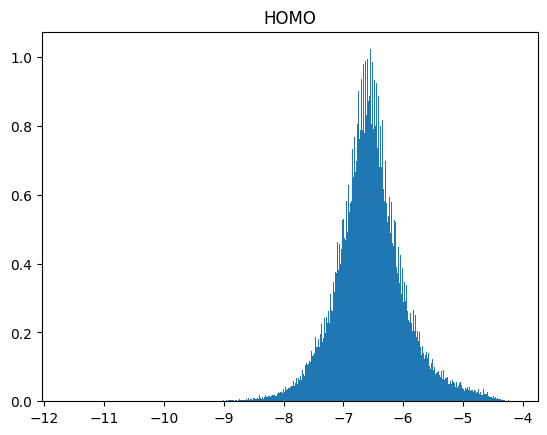

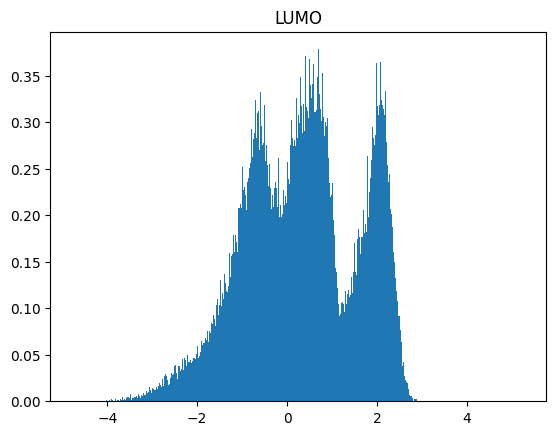

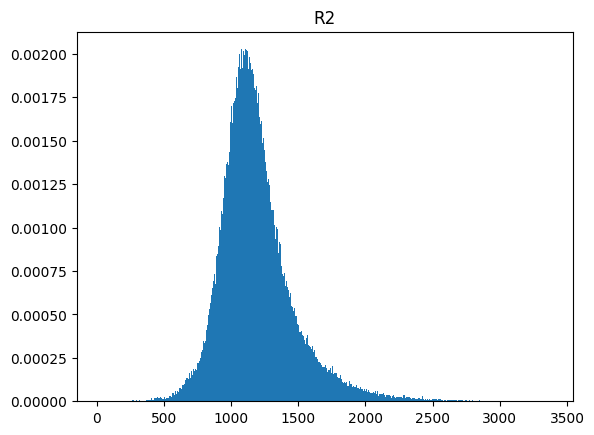

In [23]:
for i, property in enumerate(model.properties):
    plt.hist(y[:, i].cpu().numpy(), bins=512, density=True)
    plt.title(property.upper())
    plt.show()

In [71]:
full_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
dataset_smiles_with_prop = dict()
for batch in tqdm(full_loader, desc="Converting dataset graphs to SMILES"):
    for sample_index in range(len(batch)):
        sample = batch[sample_index]
        mol = graph_to_mol(data=sample, includes_h=include_hydrogen, validate=False)
        dataset_smiles_with_prop[Chem.MolToSmiles(mol)] = sample.y

Converting dataset graphs to SMILES:   0%|          | 0/501 [00:00<?, ?it/s]

Converting dataset graphs to SMILES: 100%|██████████| 501/501 [03:17<00:00,  2.54it/s]


# Optimize properties with MLE

In [197]:
def optimize_z_for_properties(model, z, properties):
    z.requires_grad_(True)
    optimizer = torch.optim.LBFGS([z], lr=1e-1)

    def closure():
        optimizer.zero_grad()
        y_mu, y_sigma = model.predict_properties(z)
        # var = y_sigma * y_sigma
        loss = ((properties - y_mu) ** 2) + (z ** 2).sum() * 1e-8

        loss = loss.mean()
        loss.backward()
        return loss
    
    for i in tqdm(range(100)):
        loss = optimizer.step(closure)

    print(f"Property optimization loss = {loss}")
    return z.detach()

In [125]:
import pandas as pd

z_list = []
props_list = []
for batch in tqdm(loader):
    z = model.encode(batch).detach().cpu()
    z = model.z_to_property_z(z)
    z_list.append(z)
    props_list.append(batch.y)

z_pca = torch.concat(z_list)
props = torch.concat(props_list)
prop_df = pd.DataFrame(props.cpu(), columns=model.properties).reset_index()

  0%|          | 0/501 [00:00<?, ?it/s]

100%|██████████| 501/501 [00:39<00:00, 12.66it/s]


100%|██████████| 100/100 [00:01<00:00, 60.46it/s]


Property optimization loss = 2.4527389541617595e-06


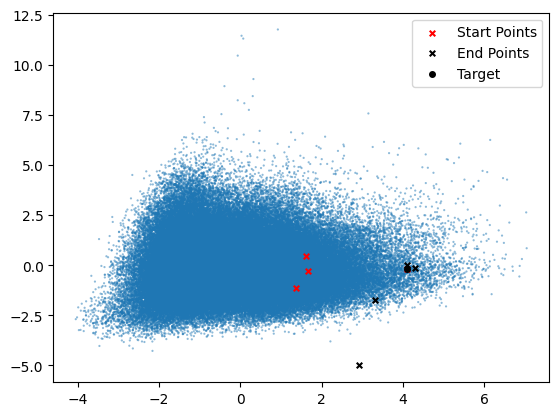

In [202]:
prop_opt = "lumo"

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


# do pca and normalize
z = z_pca
pca_transform = PCA(n_components=2)
pca_transform = pca_transform.fit(z)
Z_pca = pca_transform.transform(z)
#Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
#sdf[prop_opt] = ((prop_df[model.properties] - target_properties[0]))[prop_opt]

scatter = plt.scatter(x=df['x'], y=df['y'], marker='.',
            s=10, alpha=0.5, edgecolors='none')

target_index = 3

batch = next(iter(val_loader))
z_start_gpu = model.encode_mean(batch).detach()
z_start = z_start_gpu.cpu().numpy()
Z_pca = pca_transform.transform(z_start)
df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']

scatter = plt.scatter(x=df['x'], y=df['y'], color="red",
            marker='x', s=16, alpha=1.0, label="Start Points")

end_z = optimize_z_for_properties(
        model=model,
        z=z_start_gpu,
        properties=batch[target_index].y
    )
z_end = end_z.cpu().detach().numpy()
Z_pca = pca_transform.transform(z_end)
df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']

scatter = plt.scatter(x=df['x'], y=df['y'], color="black",
            marker='x', s=16, alpha=1.0, label="End Points")

Z_pca = pca_transform.transform(z_start[target_index:target_index+1])
df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']

scatter = plt.scatter(x=df['x'], y=df['y'], color="black",
            marker='o', s=16, alpha=1.0, label="Target")

#plt.colorbar(scatter, label=prop_opt)
plt.legend()
plt.show()